In [1]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import itertools
from tqdm import tqdm

import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
from glob import glob
import time, datetime

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
%load_ext tensorboard

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Functions

In [3]:
def plot_history_curves(model):
    '''
    Plots a model's history metric
    
    Parameters
    ------
    model - model history
    '''
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    
    accuracy = model.history['accuracy']
    val_accuracy = model.history['val_accuracy']
    
    epochs = range(len(model.history['loss']))
    
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title('Loss[lower == better]')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Val Accuracy')
    plt.title('Accuracy[higher==better]')
    plt.xlabel('Epochs')
    plt.legend()

In [4]:
def plot_random_image(class_list, directory, titles=True):
    
    '''
    Takes in a list of classes which randomly selects an image in its directory
    and outputs the image file, along with the img directory
    
    Parameters
    --------
    class_list - list of classes(similar to its folder name)
    directory - location of images you would want to view
    '''
    
    random_class = random.choice(class_list)
    random_dir = directory + random_class
    random_img = random.choice(os.listdir(random_dir))
    rng_dir_img = random_dir + '/' + random_img
    arr_dir_img = mpimg.imread(rng_dir_img)
    
    plt.axis(False)
    if titles:
        img=plt.imshow(arr_dir_img)
        plt.title(f'class:{random_class}\n shape:{arr_dir_img.shape}\n {random_img}')
    else:
        img=plt.imshow(arr_dir_img)
        
    return img, rng_dir_img

In [5]:
def compare_history(original_history, new_history, initial_epochs):
    '''
    Input model_2 then new history to show frequency of the train and val loss
    '''
    
    acc = original_history.history['accuracy']
    loss = original_history.history['loss']
    
    val_acc = original_history.history['val_accuracy']
    val_loss = original_history.history['val_loss']
    
    total_acc = acc + new_history.history['accuracy']
    total_loss = loss + new_history.history['loss']
    
    total_val_acc = val_acc + new_history.history['val_accuracy']
    total_val_loss = val_loss + new_history.history['val_loss']
    
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation History')
    
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

In [6]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    '''
    Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
      y_true: Array of truth labels (must be same shape as y_pred).
      y_pred: Array of predicted labels (must be same shape as y_true).
      classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
      figsize: Size of output figure (default=(10, 10)).
      text_size: Size of output figure text (default=15).
      norm: normalize values or not (default=False).
      savefig: save confusion matrix to file (default=False).

    Returns:
      A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
      make_confusion_matrix(y_true=test_labels, # ground truth test labels
                            y_pred=y_preds, # predicted labels
                            classes=class_names, # array of class label names
                            figsize=(15, 15),
                            text_size=10)
    '''
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),  # create enough axis slots for each class
           yticks=np.arange(n_classes),
           xticklabels=labels,  # axes will labeled with class names (if they exist) or ints
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    
    plt.xticks(rotation=90)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j] * 100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

## Scaling Up our CNN Model

From here onwards we're going to use the full 101 of food classes,
using splitting them from 75% - 25% train and test chronologically,
and generating 10% of the data from the train set.

What we're left of is 101 classes with 75 images each for the train set and 250 images for the test set.

[101 Food Dataset Paper](https://paperswithcode.com/dataset/food-101)

> To measure the performance of our rf component mining for food recognition, we introduce a novel and challenging dataset of 101 food categories, with 101’000 images. With an average accuracy of **50.76%**, our model outperforms alternative classification methods except for cnn

To gain more experience in the future, we'll do another project similar to this and beat their model score

### Parsing through the data

In [7]:
train_101_100_dir = './Food-Vision-REDO/datasets/food_101/train/'
train_101_50_dir = './Food-Vision-REDO/datasets/food_101/train_50/'
train_101_20_dir = './Food-Vision-REDO/datasets/food_101/train_20/'
train_101_10_dir = './Food-Vision-REDO/datasets/food_101/train_10/'
test_101_dir = './Food-Vision-REDO/datasets/food_101/test/'
food_101_dir = './Food-Vision-REDO/datasets/food_101/'

In [8]:
class_list_all = glob(os.path.join(test_101_dir, '*',))
class_list_all = [i.split('\\')[-1] for i in class_list_all]
class_list_all;
len(class_list_all)

101

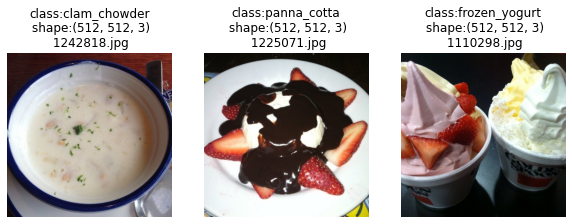

In [9]:
plt.figure(figsize=(10,10))
for i in range(1,4):
    plt.subplot(1,3,i)
    plot_random_image(class_list=class_list_all, directory=train_101_10_dir)

In [10]:
IMG_SIZE=(224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_101_10_dir,
    label_mode='categorical',
    image_size=IMG_SIZE
)

train_data_20_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_101_20_dir,
    label_mode='categorical',
    image_size=IMG_SIZE
)

train_data_50_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_101_50_dir,
    label_mode='categorical',
    image_size=IMG_SIZE
)

train_data_100_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_101_100_dir,
    label_mode='categorical',
    image_size=IMG_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_101_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    shuffle=False
)

Found 7575 files belonging to 101 classes.
Found 15150 files belonging to 101 classes.
Found 37875 files belonging to 101 classes.
Found 75750 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### Generating a reduce_lr, early stoping and checkpoint callback 

In [11]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1, 
                                                 min_lr=1e-7)

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                  patience=3)

In [13]:
def create_checkpoint_callback(checkpoint_path, metric):
    '''
    creates a checkpoint callback
    
    Parameters
    -----
    checkpoint_path - destination file path
    '''
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor=metric,
        save_weights_only=True,
        save_best_only=True,
    )
    return checkpoint_callback

In [14]:
chck_pth = './Food-Vision-REDO/checkpoint/checkpoint.ckpt'
checkpoint_callback = create_checkpoint_callback(chck_pth, metric='accuracy')

## Building our CNN Model

#### Building Model 0

**Experiment** - Model 0  
**Data** - 10%  
**Preprocessing** - Augmentation  
**Model** - Feature Extraction of a Transfer Learning Model 


In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2)
], name = 'data_augmentation')

In [16]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE+(3,), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling')(x)
x = tf.keras.layers.Dense(len(class_list_all), name='dense_layer')(x)
outputs = tf.keras.layers.Activation('softmax', dtype=tf.float32, name='output_layer')(x)

model_0 = tf.keras.Model(inputs, outputs)


In [17]:
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy'])

model_0_history = model_0.fit(
    train_data_10_percent,
    epochs=5,
    validation_data=test_data,
    validation_steps=int(.15*len(test_data)),
    callbacks=[checkpoint_callback]
)

Epoch 1/5
237/237 [==============================] - 30s 99ms/step - loss: 3.4171 - accuracy: 0.2603 - val_loss: 2.6499 - val_accuracy: 0.4311
Epoch 2/5
237/237 [==============================] - 21s 87ms/step - loss: 2.2630 - accuracy: 0.4867 - val_loss: 2.2666 - val_accuracy: 0.4695
Epoch 3/5
237/237 [==============================] - 19s 80ms/step - loss: 1.9053 - accuracy: 0.5465 - val_loss: 2.0837 - val_accuracy: 0.5008
Epoch 4/5
237/237 [==============================] - 19s 81ms/step - loss: 1.6846 - accuracy: 0.5958 - val_loss: 2.0556 - val_accuracy: 0.4952
Epoch 5/5
237/237 [==============================] - 19s 78ms/step - loss: 1.5455 - accuracy: 0.6186 - val_loss: 2.0287 - val_accuracy: 0.5016


In [18]:
model_0_evaluation = model_0.evaluate(test_data)
model_0_evaluation

790/790 [==============================] - 49s 61ms/step - loss: 1.8712 - accuracy: 0.5246


[1.8711650371551514, 0.5246336460113525]

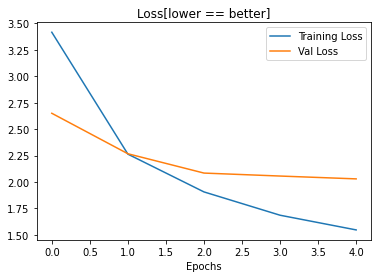

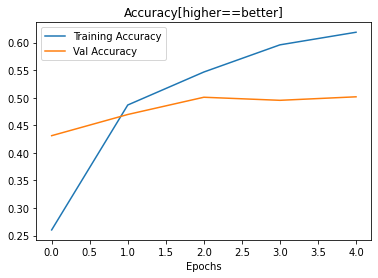

In [19]:
plot_history_curves(model_0_history)

The model is definitely learning, but is also overfitting on the later epochs

####  Building Model 1

**Experiment** - Model 1   
**Data** - 10%  
**Preprocessing** - Augmentation  
**Model** - Feature Extraction + Fine Tuning
**Checkpoint** - From the final epoch of the previous model(model_0)

* make last 10 trainable for `base_model` 
* use `model_0` to compile and fit
* when fitting change `initial epoch` to model_0's final `epoch`
* increase the `epochs` and `learning rate`

> 🔑 When increasing `learning_rate` also increase `epochs`

In [20]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-5]:
    layer.trainable = False
    
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       metrics=['accuracy'])

In [21]:
model_1_history = model_0.fit(
    train_data_10_percent,
    epochs=len(model_0_history.epoch)+5,
    initial_epoch=model_0_history.epoch[-1],
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
    callbacks=[checkpoint_callback]
)

Epoch 5/10
237/237 [==============================] - 37s 129ms/step - loss: 1.4449 - accuracy: 0.6441 - val_loss: 1.9636 - val_accuracy: 0.5109
Epoch 6/10
237/237 [==============================] - 19s 78ms/step - loss: 1.3193 - accuracy: 0.6743 - val_loss: 2.0335 - val_accuracy: 0.4955
Epoch 7/10
237/237 [==============================] - 18s 76ms/step - loss: 1.2171 - accuracy: 0.6948 - val_loss: 1.9955 - val_accuracy: 0.4992
Epoch 8/10
237/237 [==============================] - 18s 77ms/step - loss: 1.1357 - accuracy: 0.7178 - val_loss: 1.9575 - val_accuracy: 0.5061
Epoch 9/10
237/237 [==============================] - 18s 74ms/step - loss: 1.0802 - accuracy: 0.7298 - val_loss: 1.9746 - val_accuracy: 0.5072
Epoch 10/10
237/237 [==============================] - 18s 75ms/step - loss: 1.0224 - accuracy: 0.7452 - val_loss: 1.9641 - val_accuracy: 0.5061


In [22]:
model_1_evaluation = model_0.evaluate(test_data)
model_1_evaluation

790/790 [==============================] - 32s 41ms/step - loss: 1.8190 - accuracy: 0.5371


[1.818997859954834, 0.5370693206787109]

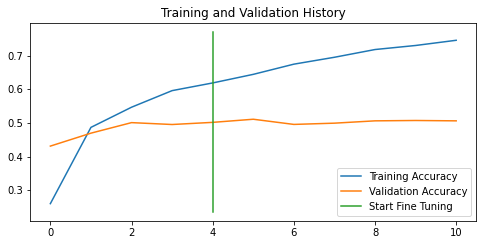

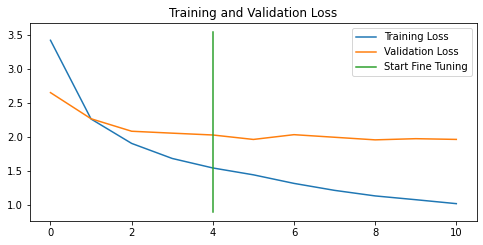

In [23]:
compare_history(model_0_history, model_1_history, initial_epochs=5)

####  Building Model 2

**Experiment** - Model 2   
**Data** - 50%  
**Preprocessing** - Augmentation  
**Model** - Feature Extraction + Fine Tuning  
**Checkpoint** - From the final epoch of the previous model(model_0)


In [24]:
for layer in base_model.layers[:-5]:
    layer.trainable = False

model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])

model_2_history = model_0.fit(
    train_data_50_percent,
    epochs=len(model_0_history.epoch)+5,
    initial_epoch=model_0_history.epoch[-1],
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
    callbacks=[checkpoint_callback]
)

Epoch 5/10
1184/1184 [==============================] - 70s 55ms/step - loss: 1.7261 - accuracy: 0.5679 - val_loss: 1.7922 - val_accuracy: 0.5434
Epoch 6/10
1184/1184 [==============================] - 63s 54ms/step - loss: 1.5633 - accuracy: 0.6013 - val_loss: 1.7335 - val_accuracy: 0.5577
Epoch 7/10
1184/1184 [==============================] - 62s 52ms/step - loss: 1.4632 - accuracy: 0.6220 - val_loss: 1.7088 - val_accuracy: 0.5673
Epoch 8/10
1184/1184 [==============================] - 61s 52ms/step - loss: 1.4025 - accuracy: 0.6370 - val_loss: 1.6651 - val_accuracy: 0.5726
Epoch 9/10
1184/1184 [==============================] - 61s 51ms/step - loss: 1.3457 - accuracy: 0.6476 - val_loss: 1.6938 - val_accuracy: 0.5654
Epoch 10/10
1184/1184 [==============================] - 61s 51ms/step - loss: 1.3043 - accuracy: 0.6567 - val_loss: 1.6878 - val_accuracy: 0.5675


In [25]:
model_2_evaluation = model_0.evaluate(test_data)
model_2_evaluation

790/790 [==============================] - 32s 41ms/step - loss: 1.5275 - accuracy: 0.6083


[1.5274989604949951, 0.6082772016525269]

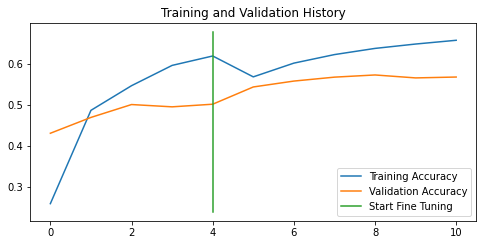

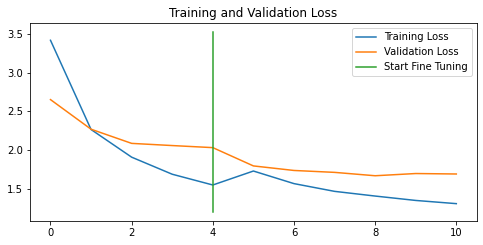

In [26]:
compare_history(model_0_history, model_2_history, initial_epochs=5)

In [27]:
model_0.save(filepath='./Food-Vision-REDO/models/101_food_class_50_percent_model.h5')

C:\Users\gilgamesh\Anaconda3\envs\tf_gpu_4\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


###  [Postponed until fixed] Saving and loading our model

loading a model with hd5 file is slightly different that the model at hand
saving a model compiled with regular .tf file isn't working and causes an error when done so

In [28]:
#model_0.save(filepath='./Food-Vision-REDO/models/101_food_class_10_percent_model')

In [29]:
# loaded_model = tf.keras.models.load_model('./Food-Vision-REDO/models/101_food_class_10_percent_model.h5')
# loaded_model.trainable = True

# for layer in loaded_model.layers[2].layers[:-5]:
#     layer.trainable = False
        
# loaded_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
#                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#                        metrics=['accuracy'])

# loaded_model_history = loaded_model.fit(
#     train_data_all_10_percent,
#     epochs=len(model_0_history.epoch)+5,
#     initial_epoch=model_0_history.epoch[-1],
#     validation_data=test_data,
#     validation_steps=int(0.15*len(test_data)),
#     callbacks=[checkpoint_callback]
# )

In [30]:
# loaded_model_results = loaded_model.evaluate(test_data)
# loaded_model_results

In [31]:
#for layer in loaded_model.layers:
#    print(layer.name, layer.trainable)

In [32]:
#for layer_number, layer in enumerate(loaded_model.layers[2].layers):
#    print(layer_number, layer.name, layer.trainable)

In [33]:
#loaded_model.summary()

### Using our Model and Making Predictions

> First we'll predict use the model to predict in each of every classes we have in our test set

In [34]:
# predicting the test data
pred_probs = model_0.predict(test_data, verbose=1)

790/790 [==============================] - 32s 39ms/step


>which is then unbatched, since our test data is batched from preprocessing 

In [35]:
# predicting shows unbatched set
pred_probs.shape

(25250, 101)

>This shows each prediction for `sample[0]`, take note that we didnt shuffle our test data,
so it's basically the `index[0]` of our classlist... the results shown below are:  
**HOW LIKELY IS INDEX[0] TO BE THE PREDICTED_PROBABILITY/RESULT, AMONG THE 101 CLASSES RANGING FROM 0-1(0-100%)**

In [36]:
# prediction for sample[0]
print(f'Number of prediction probability for sample 0:{len(pred_probs[0])}') 
print(f'What Prediction Probability sample 0 looks like: \n{pred_probs[0]}')
print(f'What class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}')

Number of prediction probability for sample 0:101
What Prediction Probability sample 0 looks like: 
[4.8857683e-01 4.3251463e-03 5.8124688e-02 1.5035753e-06 3.9471276e-04
 7.4432370e-07 2.1666646e-02 2.5576676e-06 4.0157619e-03 4.9493287e-06
 1.9676664e-03 1.5757333e-06 1.2050476e-02 4.6578589e-07 2.1926206e-04
 3.2781914e-05 6.3188796e-05 9.9022371e-05 7.3025416e-04 1.4718361e-05
 8.8417022e-05 6.9253560e-06 1.4099326e-05 2.0922133e-04 5.1775045e-05
 3.0620411e-04 4.3337773e-06 6.9378598e-07 1.7965690e-04 5.0773622e-05
 4.2832876e-06 5.8414736e-03 5.8614737e-03 8.1576275e-08 3.1516649e-07
 1.7274855e-05 4.9582650e-07 2.8990826e-04 5.9592712e-05 5.0972347e-05
 1.3857789e-03 4.8828515e-05 7.2432570e-03 9.9409932e-05 2.5979450e-06
 6.9232890e-08 5.8982387e-02 1.2954777e-03 1.3876593e-07 1.1222379e-03
 3.6791270e-04 3.6428293e-05 2.6202759e-01 8.4698317e-05 1.5513039e-06
 3.6504961e-04 1.5126368e-05 5.0664940e-03 3.4760120e-05 1.5762039e-04
 8.0022337e-06 4.2762063e-04 2.0557574e-04 5.086

> The output below shows our model's predictions towards the images from the test data,  
again the test data isn't shuffled or in random, which is why he can already see our model's wrong prediction

In [38]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([ 0, 14, 98,  2, 18,  0,  0, 21, 17,  0], dtype=int64)

In [39]:
len(pred_classes)

25250

> Unbatching our test data to compare predictions

In [40]:
y_labels = []

for images, labels in tqdm(test_data.unbatch()):
        y_labels.append(labels.numpy().argmax())
        
y_labels[:10]

25250it [00:11, 2286.40it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [41]:
len(y_labels)

25250

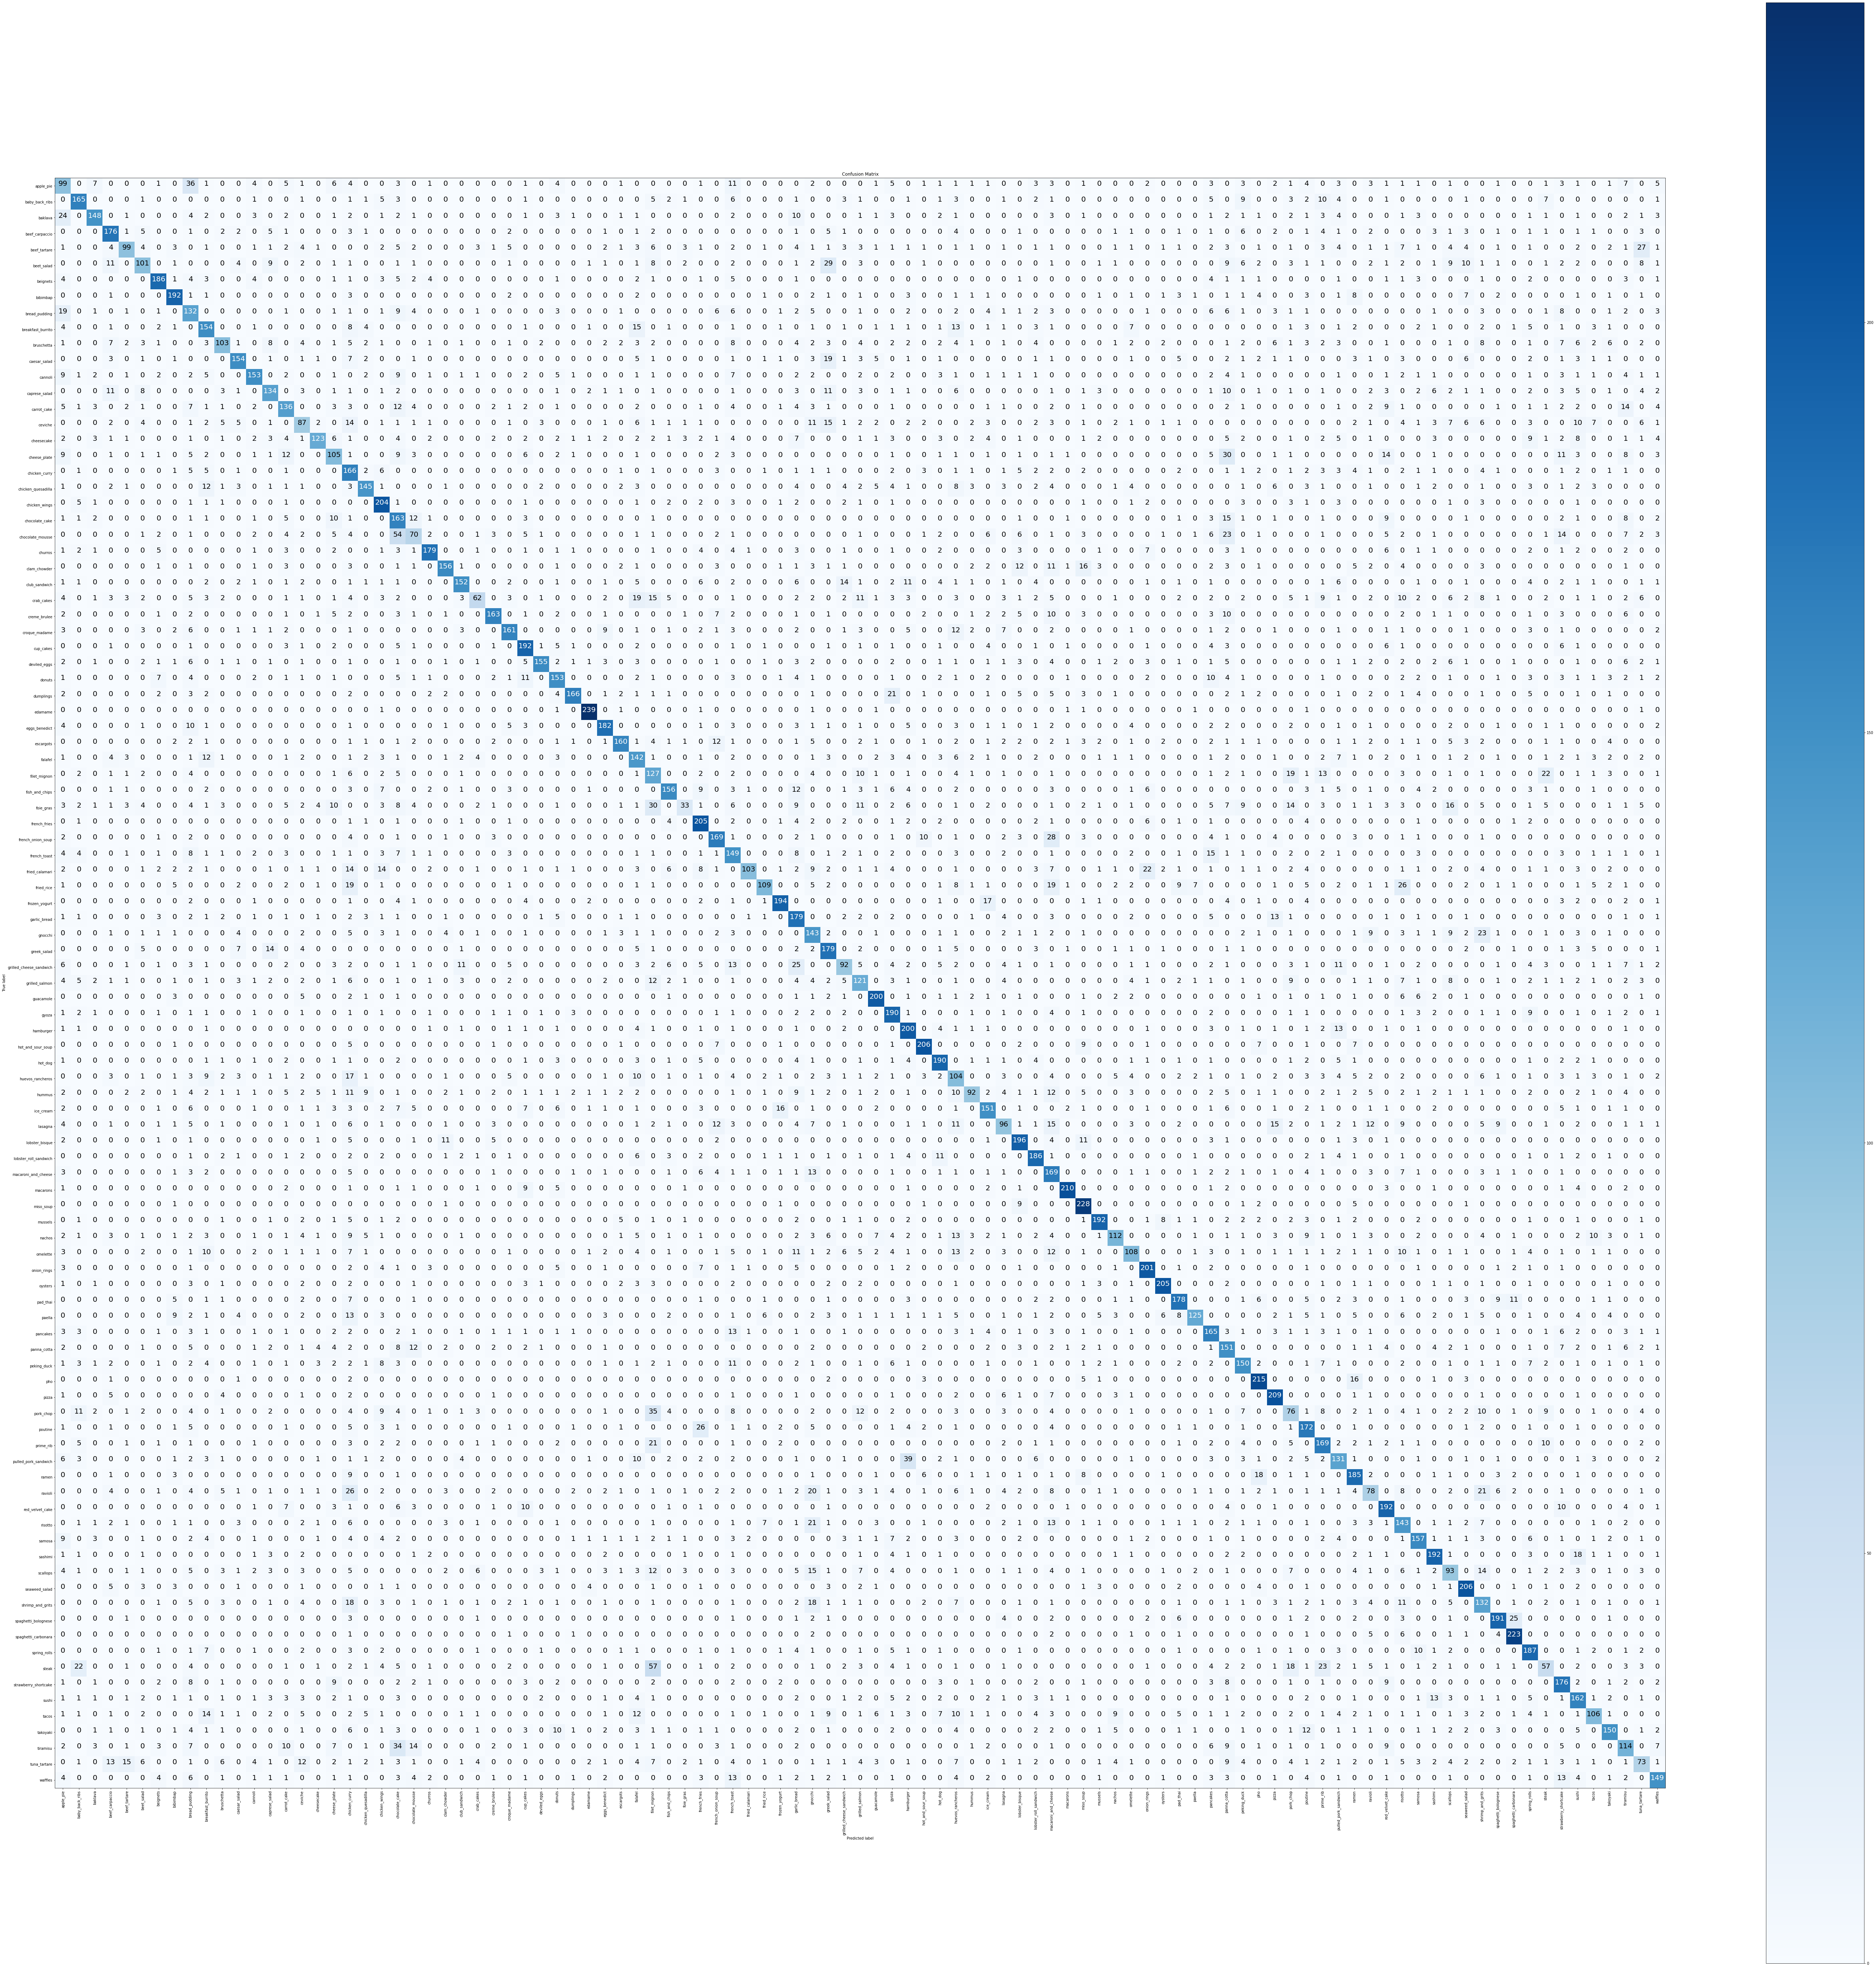

In [59]:
make_confusion_matrix(y_true=y_labels, y_pred=pred_classes, classes=class_list_all, figsize=(100,100), text_size=20)


> `f1-score` is the combination of both precision and recall, it's also the metrics we're going to use  
to compare our different predictions.

the method below returns a dictionary of predictions

In [60]:
classification_report_dict = classification_report(y_true=y_labels, y_pred=pred_classes, output_dict=True)

In [61]:
class_f1_scores = {}

for key, value in classification_report_dict.items():
    if key == 'accuracy':
        break
    else:
        class_f1_scores[class_list_all[int(key)]] = value['f1-score']

In [62]:
class_f1_scores

{'apple_pie': 0.3694029850746268,
 'baby_back_ribs': 0.66,
 'baklava': 0.6757990867579908,
 'beef_carpaccio': 0.6692015209125475,
 'beef_tartare': 0.4974874371859297,
 'beet_salad': 0.4730679156908665,
 'beignets': 0.7576374745417516,
 'bibimbap': 0.7695390781563127,
 'bread_pudding': 0.4230769230769231,
 'breakfast_burrito': 0.5724907063197027,
 'bruschetta': 0.49638554216867475,
 'caesar_salad': 0.6724890829694323,
 'cannoli': 0.6666666666666666,
 'caprese_salad': 0.5903083700440529,
 'carrot_cake': 0.5494949494949495,
 'ceviche': 0.39545454545454545,
 'cheesecake': 0.6044226044226044,
 'cheese_plate': 0.4595185995623633,
 'chicken_curry': 0.4272844272844273,
 'chicken_quesadilla': 0.6516853932584269,
 'chicken_wings': 0.7071057192374349,
 'chocolate_cake': 0.47660818713450287,
 'chocolate_mousse': 0.33898305084745767,
 'churros': 0.7732181425485961,
 'clam_chowder': 0.697986577181208,
 'club_sandwich': 0.6846846846846847,
 'crab_cakes': 0.3542857142857143,
 'creme_brulee': 0.7180616

> Building a dataframe and plotting to make things all tidy and visual

In [63]:
f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()),
                   'f1-score': list(class_f1_scores.values())}).sort_values('f1-score', ascending=False)

In [64]:
f1_scores['f1-score']

33    0.939096
63    0.886076
69    0.847107
91    0.841509
54    0.820717
        ...   
99    0.341920
22    0.338983
77    0.329718
93    0.291560
39    0.215686
Name: f1-score, Length: 101, dtype: float64

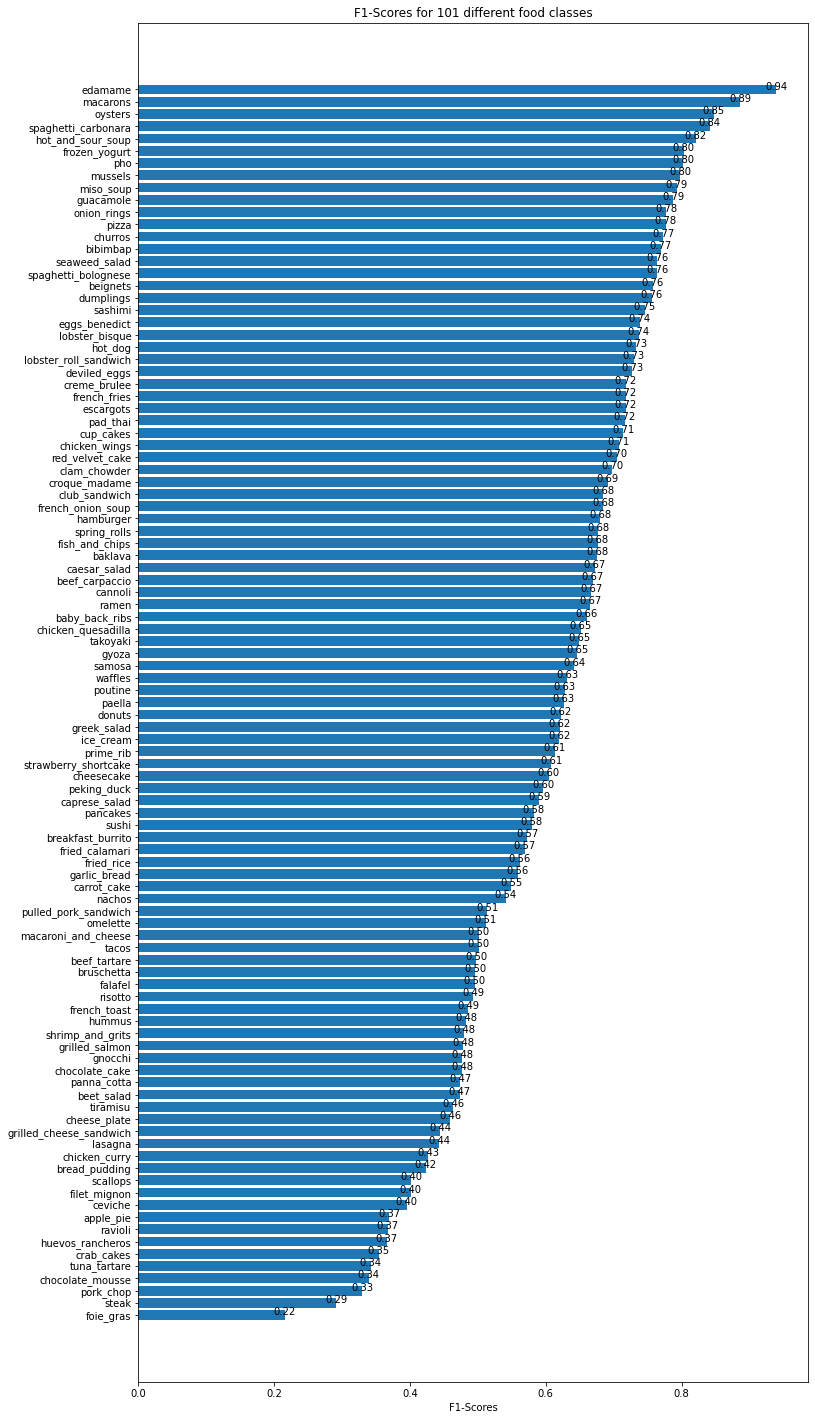

In [65]:
fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names']);
ax.set_xlabel('F1-Scores')
ax.set_title('F1-Scores for 101 different food classes')
ax.invert_yaxis();

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')
        
autolabel(scores)

### Making use of our model for predictions

> we'll first have to preprocess the image before we could pass it to our model  
we have to set the image's properties same as how we preprocessed our images.  
read -> decode -> resize -> rescale rgb


In [66]:
def load_and_prep_image(filename, img_shape=224, scale=True):
    img = tf.io.read_file(filename)
    
    img = tf.io.decode_image(img, channels=3)
    
    img = tf.image.resize(img, size=[img_shape, img_shape])
    
    if scale:
        return img/255.
    else:
        return img

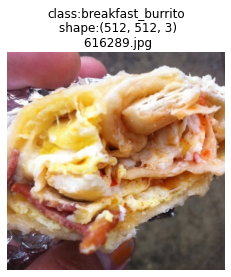

In [67]:
random_class = [np.random.choice(class_list_all)]
img, img_dir = plot_random_image(random_class, test_101_dir, titles=True)

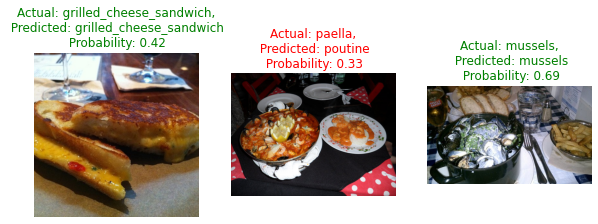

In [68]:
plt.figure(figsize=(10,10))
for i in range(3):
    # select random class
    random_class = [np.random.choice(class_list_all)]
    
    # build subplot
    plt.subplot(1,3, i+1)
    
    # generate img and its img directory from the test directory
    img, img_dir = plot_random_image(random_class, test_101_dir, titles=False)
    
    # load and prepare the image
    img = load_and_prep_image(img_dir, scale=False)
    
    # predict the probability of the img being its class
    pred_prob = model_0.predict(tf.expand_dims(img, axis=0))
    
    # get the class of the image
    pred_class = class_list_all[pred_prob.argmax()]
    
    plt.axis(False)
    
    # visualize if predictions are predicted properly
    if random_class[0] == pred_class:
        title_color = 'g'
    else:
        title_color = 'r'
        
    plt.title(f'Actual: {random_class[0]},\n Predicted: {pred_class}\n Probability: {pred_prob.max():.2f}', c=title_color)

## Finding the most Wrong Prediction

In [69]:
filepaths = []
for filepath in test_data.list_files(test_101_dir+'*/*.jpg',
                                     shuffle=False):
    filepaths.append(filepath.numpy())
filepaths;

In [70]:
pred_df = pd.DataFrame({
    'img_path': filepaths,
    'y_true': y_labels,
    'y_pred': pred_classes,
    'pred_conf': pred_probs.max(axis=1),
    'y_true_classname': [class_list_all[i] for i in y_labels],
    'y_pred_classname': [class_list_all[i] for i in pred_classes]
})

In [71]:
pred_df['pred_correct'] = pred_df['y_true'] == pred_df['y_pred']

In [72]:
pred_df;

In [73]:
top_wrong = pred_df[pred_df['pred_correct'] == False].sort_values(by='pred_conf', ascending=False).reset_index()

In [74]:
top_wrong

,index,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,20887,b'.\\Food-Vision-REDO\\datasets\\food_101\\tes...,83,63,0.999971,red_velvet_cake,macarons,False
1,14672,b'.\\Food-Vision-REDO\\datasets\\food_101\\tes...,58,45,0.998839,ice_cream,frozen_yogurt,False
2,16346,b'.\\Food-Vision-REDO\\datasets\\food_101\\tes...,65,69,0.998588,mussels,oysters,False
3,17792,b'.\\Food-Vision-REDO\\datasets\\food_101\\tes...,71,65,0.997017,paella,mussels,False
4,1109,b'.\\Food-Vision-REDO\\datasets\\food_101\\tes...,4,69,0.996634,beef_tartare,oysters,False
...,...,...,...,...,...,...,...,...
9886,19329,b'.\\Food-Vision-REDO\\datasets\\food_101\\tes...,77,96,0.078819,pork_chop,tacos,False
9887,6868,b'.\\Food-Vision-REDO\\datasets\\food_101\\tes...,27,14,0.077871,creme_brulee,carrot_cake,False
9888,15753,b'.\\Food-Vision-REDO\\datasets\\food_101\\tes...,63,22,0.077533,macarons,chocolate_mousse,False
9889,10752,b'.\\Food-Vision-REDO\\datasets\\food_101\\tes...,43,46,0.074345,fried_calamari,garlic_bread,False


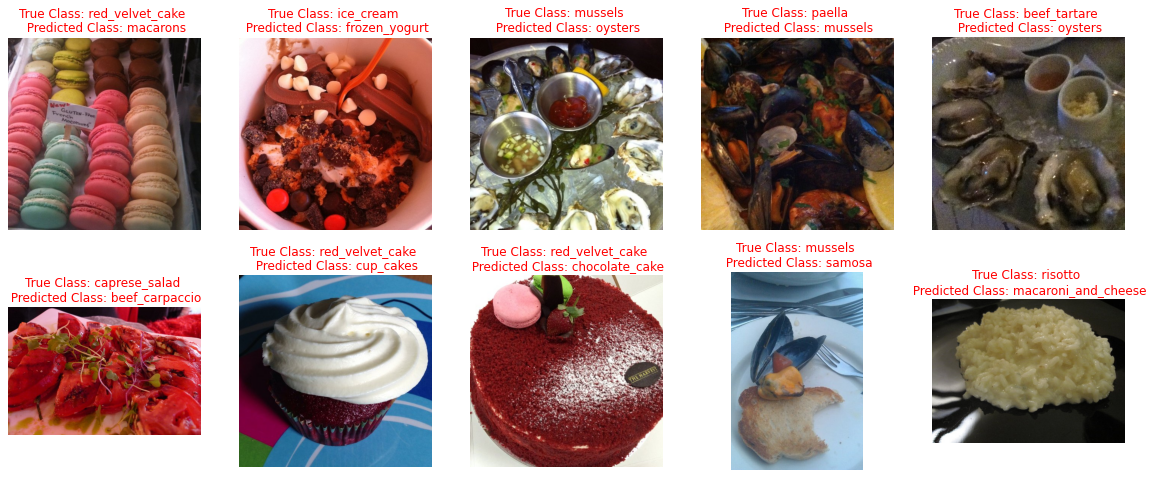

In [75]:
plt.figure(figsize=(20,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    img = mpimg.imread(top_wrong['img_path'][i].decode("utf-8") )
    plt.imshow(img)
    plt.axis(False)
    plt.title(f"True Class: {top_wrong['y_true_classname'][i]} \n Predicted Class: {top_wrong['y_pred_classname'][i]}", c='r')

# Takeaways

* if overfitting on too much data, try to make your model simpler  
* if you have a lot of data dont augment, just feed data normally
* prefetch to load files faster
* user mixed_precision for faster training